In [1]:
import bz2
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from colossus.cosmology import cosmology  
from colossus.halo import mass_so
from colossus.lss import mass_function
from bisect import bisect_left
import healpy as hp
import skymapper as skm
import random
import scipy.stats

def vc(M,Omega_m,Omega_lambda,h,z):
    Delta_c = mass_so.deltaVir(z)
    v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    return v_c

def sigma_1(M_cosmohub):
    M = np.logspace(10,15,1000)
    sigma_alpha = 0.5*abs(M_HI_no_disp(M,alpha1,beta,v_c0,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)) - M_HI_no_disp(M,alpha2,beta,v_c0,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)))
    sigma_beta = 0.5*abs(M_HI_no_disp(M,alpha,beta1,v_c0,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)) - M_HI_no_disp(M,alpha,beta2,v_c0,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)))
    sigma_v_c0 = 0.5*abs(M_HI_no_disp(M,alpha,beta,v_c0_1,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)) - M_HI_no_disp(M,alpha,beta,v_c0_2,v_c1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1))) 
    sigma_v_c1 = 0.5*abs(M_HI_no_disp(M,alpha,beta,v_c0,v_c1_1,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)) - M_HI_no_disp(M,alpha,beta,v_c0,v_c1_2,Omega_m,Omega_b,h,1,mass_so.deltaVir(1),vc(M,Omega_m,Omega_lambda,h,1)))
    sigma = np.sqrt(sigma_alpha**2+sigma_beta**2+sigma_v_c0**2+sigma_v_c1**2)
    indices = np.digitize(M_cosmohub, M, right=False) 
    indices = indices - 1
    sigma_1 = sigma[indices]
    return sigma_1

def M_HI_no_disp(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c,v_c):
    #v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    f=(Omega_b/Omega_m)*(0.75) # (1-Y)*Omega_b/Omega_m
    resul_teorico = alpha*f*M*((M*h/1e11)**beta)*np.exp(-(v_c0/v_c)**3)*np.exp(-(v_c/v_c1)**3)
    return resul_teorico

def M_HI(M,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z,Delta_c,v_c,sigma):
    #v_c=96.6*((Delta_c*Omega_m*(h**2)/24.4)**(1/6))*(((1+z)/3.3)**(1/2))*((M/10**11)**(1/3))
    f=(Omega_b/Omega_m)*(0.75) # (1-Y)*Omega_b/Omega_m
    resul_teorico = alpha*f*M*((M*h/1e11)**beta)*np.exp(-(v_c0/v_c)**3)*np.exp(-(v_c/v_c1)**3)
    resul_real = scipy.stats.norm.rvs(resul_teorico, sigma, (1,len(resul_teorico)))[0]
    return resul_real

def n_sin_A(Masa, z):
    n_sin_A = mass_function.massFunction(Masa, z, mdef = 'fof', model = 'crocce10', q_out = 'dndlnM')
    return n_sin_A

def n(Masa, z):
    n = (1/A)*mass_function.massFunction(Masa, z, mdef = 'fof', model = 'crocce10', q_out = 'dndlnM')
    return n

In [2]:
alpha1 = 0.17 + 0.02
alpha2 = 0.17 - 0.02
beta1 = -0.55 + 0.12 
beta2 = -0.55 - 0.12  
v_c0_1 = 37.1535 + 37.1535*0.03  
v_c0_2 = 37.1535 - 37.1535*0.03 
v_c1_1 = 24547.08916 + 24547.08916*0.75
v_c1_2 = 24547.08916 - 24547.08916*0.75

In [3]:
data = pd.read_csv("/scratch/davfer/Cosmohub/9477.csv.bz2", sep=",", comment='#', na_values=r'\N')

unique_halo_id = data['unique_halo_id'].values
v_vir_cosmohub = data['v_vir'].values
z_cosmohub = data['z_cgal'].values
M_cosmohub = 10**data['lmhalo'].values
ra_gal = data['ra_gal'].values
dec_gal = data['dec_gal'].values

print(len(unique_halo_id),len(v_vir_cosmohub),len(z_cosmohub),len(M_cosmohub),flush=True)
print(len(set(unique_halo_id)),flush=True)

inds = []
unique_halo_id_sin_repetir = []
seen = set()
for i, halo in enumerate(unique_halo_id):
    if halo not in seen:
        inds.append(i)
        unique_halo_id_sin_repetir.append(halo)
        seen.add(halo)

unique_halo_id = unique_halo_id_sin_repetir
v_vir_cosmohub = v_vir_cosmohub[inds]
z_cosmohub = z_cosmohub[inds]
M_cosmohub = M_cosmohub[inds]
ra_gal = ra_gal[inds]
dec_gal = dec_gal[inds]
print(len(v_vir_cosmohub),len(z_cosmohub),len(M_cosmohub), flush=True)

data_halo = data.iloc[inds]

params = cosmology.cosmologies['planck15']
params['Om0'] = 0.25
params['Ob0'] = 0.044
params['Ode0'] = 0.75
params['H0'] = 70
params['sigma8'] = 0.8
params['ns'] = 0.95
cosmo = cosmology.setCosmology('planck15',params)


# Parámetros de MICECAT (Best fit (WHISP))
Omega_m = 0.25
Omega_b = 0.044
Omega_lambda = 0.75
h = 0.7
alpha = 0.17
beta = -0.55
v_c0 = 37.1535  #km/s
v_c1 = 24547.08916 #km/s
M=np.logspace(10,15,100)  #En unidades solares

z_bin_edges = np.linspace(0.8,0.9,11)
z_bin_edges_izq = z_bin_edges[:-1]
z_bin_edges_der = z_bin_edges[1:]
z_bin_centers = (z_bin_edges_izq + z_bin_edges_der)/2

499609997 499609997 499609997 499609997
329344245
329344245 329344245 329344245


90.00008 0.02068199999999365
90.0 -269.99965
90.0 0.07979600000000175
90.0 0.0
90.000119 0.04205000000000325
90.0 0.0
90.0 0.04496699999999976
90.0 -269.999814
90.000114 0.054000000000002046
90.0 -8e-05
90.0 0.10679600000000278
90.0 -269.999948
90.0 0.04691200000000606
90.0 -269.99992599999996
90.0 0.024020999999990522
90.0 0.0
90.0 0.005921000000000731
90.0 0.0
90.0 0.010207999999991557
90.0 -0.00010400000000000001


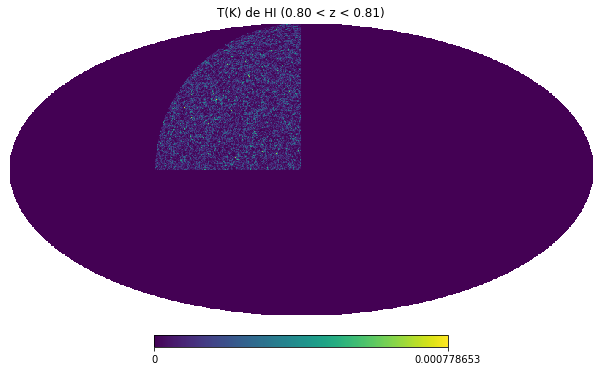

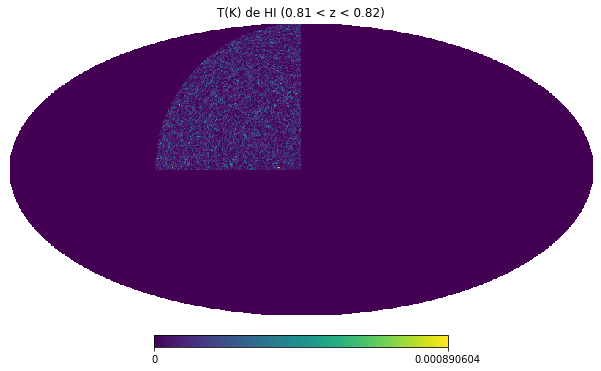

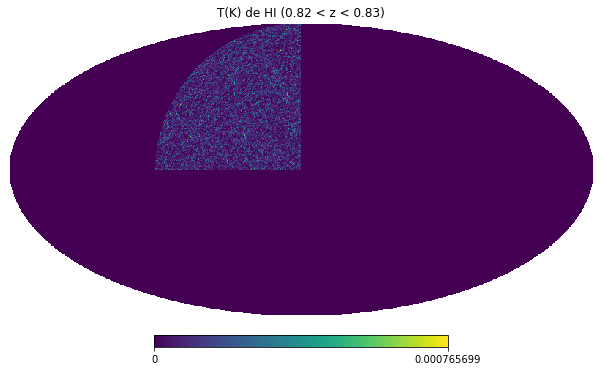

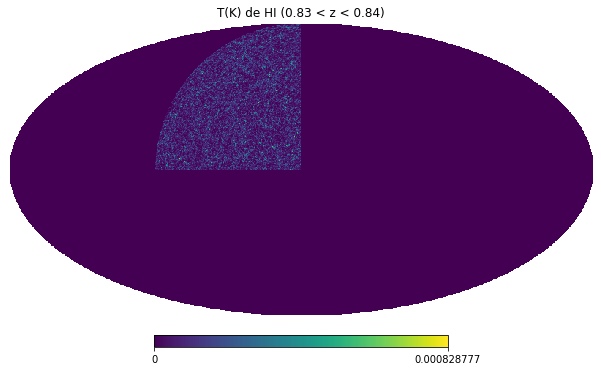

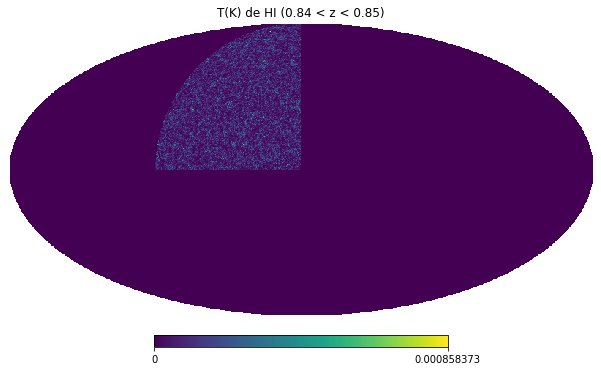

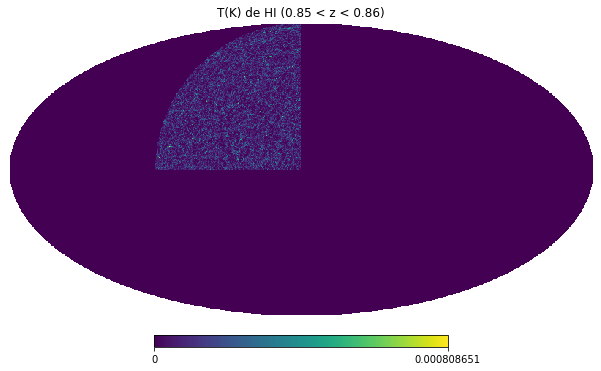

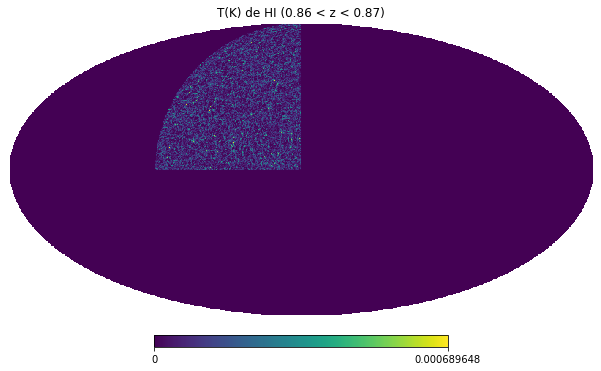

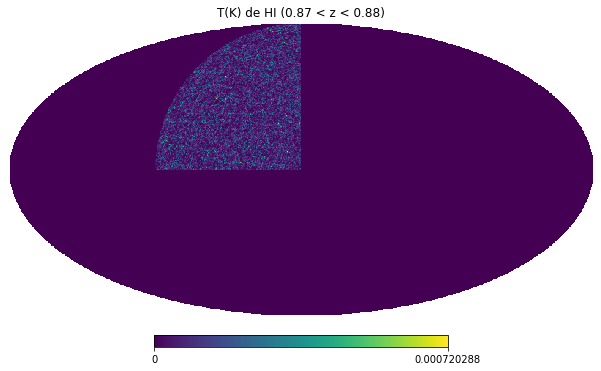

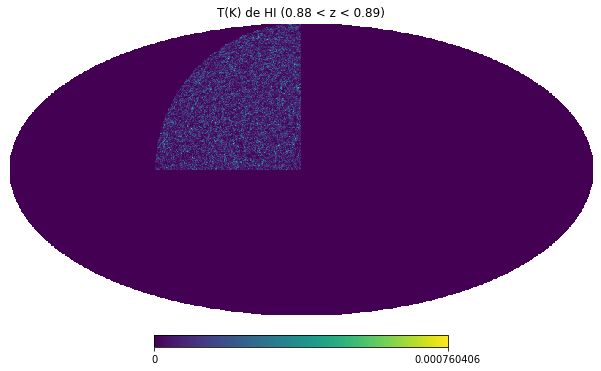

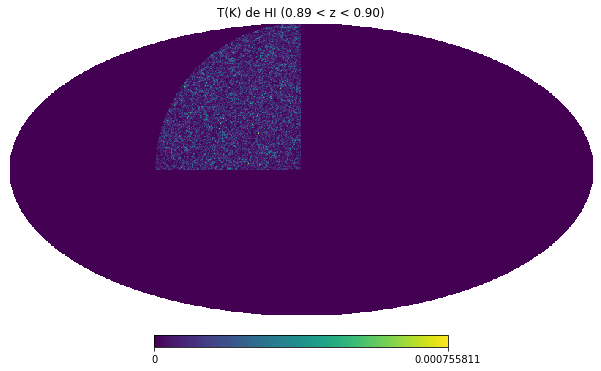

In [10]:
T_bins_mollview_medias_todo_mapa = []
T_bins_mollview_medias_pix1 = []
T_bins_mollview_medias_pix2 = []
T_bins_mollview_medias_pix3 = []
T_bins_mollview_medias_pix4 = []

elem1 = random.randint(0, 98559)
elem2 = random.randint(0, 98559)
elem3 = random.randint(0, 98559)
elem4 = random.randint(0, 98559)    #Mínimos y máximos de los píxeles de la zona ocupada


nside = 256
Apixel = hp.nside2pixarea(nside, degrees=False)
npix = hp.nside2npix(nside)

ipix_zona_ocupada = []
for pix in range(npix):
    if (0 <= hp.pix2ang(nside,pix)[0] <= np.pi/2)&(0 <= hp.pix2ang(nside,pix)[1] <= np.pi/2):
        ipix_zona_ocupada.append(pix)

mascara_map = np.zeros(npix)
mascara_map[ipix_zona_ocupada] = 1
hp.fitsfunc.write_map('/scratch/davfer/Cosmohub/mascara_map.fits',mascara_map,nest=False,coord='C',overwrite=True)


for i in range(10):    
        
    M_bin_cosmohub = []
    z_bin_cosmohub = []
    ra_gal_bin = []
    dec_gal_bin = []
    v_vir_cosmohub_bin = []

    
    indexz = np.where((z_cosmohub>z_bin_edges_izq[i])&(z_cosmohub<z_bin_edges_der[i]))[0]
    M_bin_cosmohub = M_cosmohub[indexz]
    z_bin_cosmohub = z_cosmohub[indexz]
    ra_gal_bin = ra_gal[indexz]
    dec_gal_bin = dec_gal[indexz]
    v_vir_cosmohub_bin = v_vir_cosmohub[indexz]

    M_bin_cosmohub = np.array(M_bin_cosmohub)
    z_bin_cosmohub = np.array(z_bin_cosmohub)
    ra_gal_bin = np.array(ra_gal_bin)
    dec_gal_bin = np.array(dec_gal_bin)
    v_vir_cosmohub_bin = np.array(v_vir_cosmohub_bin)
    zhist,edges_z= np.histogram(z_bin_cosmohub,bins=100)
    z_array = (edges_z[:-1] + edges_z[1:])/2
    np.savetxt('/scratch/davfer/Cosmohub/z_array_0_{:.0f}_0_{:.0f}_disp.txt'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]),z_array)
    np.savetxt('/scratch/davfer/Cosmohub/z_hist_0_{:.0f}_0_{:.0f}_dsip.txt'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]),zhist)
       
    n = 128
    
    lado_ra = np.linspace(0,90,n+1)  #129 fronteras para que haya 128 celdas
    lado_dec = (180/np.pi)*np.arccos(np.linspace(np.cos(0),np.cos(np.pi/2),n+1))
    lado_dec_lin = np.linspace(0,90,n+1)
    lado_dec_izq = lado_dec[:-1]
    lado_dec_der = lado_dec[1:]
    lado_dec_lin_izq = lado_dec_lin[:-1]
    lado_dec_lin_der = lado_dec_lin[1:]


    delta_ra = lado_ra[1] - lado_ra[0]
    delta_dec = lado_dec[1] - lado_dec[0]

    Vcelda_esferica = (((np.cos(lado_dec_izq*2*np.pi/360)-np.cos(lado_dec_der*2*np.pi/360))*delta_ra*2*np.pi/360)/(4*np.pi))*(4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)
    Vcelda_esferica_lin = (((np.cos(lado_dec_lin_izq*2*np.pi/360)-np.cos(lado_dec_lin_der*2*np.pi/360))*delta_ra*2*np.pi/360)/(4*np.pi))*(4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)


    #Esta vez se van a ir guardando según sus coordenadas angulares

    #Se clasifican en celdas de manera que el límite superior de la celda cuenta 
    #como la celda anterior (excepto el primer límite de la primera celda,
    #que cuenta como la primera celda).


    
    lado_ra_sample = np.linspace(35,40,n+1)  #129 fronteras para que haya 128 celdas
    lado_dec_sample = np.linspace(35,40,n+1)


    delta_ra_sample = lado_ra_sample[1] - lado_ra_sample[0]
    delta_dec_sample = lado_dec_sample[1] - lado_dec_sample[0]

    Vcelda_esferica_sample = (((1-np.cos(delta_dec_sample*2*np.pi/360))*delta_ra_sample*2*np.pi/360)/(4*np.pi))*(4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)
    V_corteza = (4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)

    Vcelda_esferica_sample = (((1-np.cos(delta_dec_sample*2*np.pi/360))*delta_ra_sample*2*np.pi/360)/(4*np.pi))*V_corteza

    Vcelda_esferica_sample_2 = (delta_ra_sample*delta_dec_sample/(4*np.pi*(180/np.pi)**2))*V_corteza

    Vcelda_esferica_sample_3 = (5**2/(4*np.pi*(180/np.pi)**2))*V_corteza/n**2 


    #Esta vez se van a ir guardando según sus coordenadas angulares

    #Se clasifican en celdas de manera que el límite superior de la celda cuenta 
    #como la celda anterior (excepto el primer límite de la primera celda,
    #que cuenta como la primera celda).

    #dec_gal_sample = dec_gal_bin[np.where((ra_gal_bin>35)&(ra_gal_bin<40)&(dec_gal_bin>35)&(dec_gal_bin<40))[0]]
    #ra_gal_sample = ra_gal_bin[np.where((ra_gal_bin>35)&(ra_gal_bin<40)&(dec_gal_bin>35)&(dec_gal_bin<40))[0]]
    #M_sample = M_bin_cosmohub[np.where((ra_gal_bin>35)&(ra_gal_bin<40)&(dec_gal_bin>35)&(dec_gal_bin<40))[0]]
    #z_cosmohub_sample = z_bin_cosmohub[np.where((ra_gal_bin>35)&(ra_gal_bin<40)&(dec_gal_bin>35)&(dec_gal_bin<40))[0]]
    #v_vir_sample = v_vir_cosmohub_bin[np.where((ra_gal_bin>35)&(ra_gal_bin<40)&(dec_gal_bin>35)&(dec_gal_bin<40))[0]]
    

    #Densidad_sample_2D_oscura = np.zeros((n,n))

    #angulos_dec = []
    #angulos_ra = []

    #for dec,ra,m in zip(dec_gal_sample,ra_gal_sample,M_sample):
        #ang_dec = bisect_left(lado_dec_sample, dec)  #np.digitize
        #ang_dec = ang_dec - 1
        #if ang_dec == -1:
            #ang_dec = 0
        #ang_ra = bisect_left(lado_ra_sample, ra)
        #ang_ra = ang_ra - 1
        #if ang_ra == -1:
            #ang_ra = 0
        #angulos_dec.append(ang_dec)
        #angulos_ra.append(ang_ra)
        #Densidad_sample_2D_oscura[ang_dec,ang_ra] = Densidad_sample_2D_oscura[ang_dec,ang_ra] + (m/Vcelda_esferica_sample_2)
    #Densidad_media_sample_2D_oscura = np.mean(Densidad_sample_2D_oscura)
    #Sobredensidad_media_sample_2D_oscura = Densidad_sample_2D_oscura/Densidad_media_sample_2D_oscura - 1
    #Primer indice controla la fila
    #y el segundo la columna de esa matriz.


    #plt.figure()
    #fig_imshow = plt.imshow(Densidad_sample_2D_oscura)
    #ax = plt.gca() 
    #ax.invert_yaxis()
    #plt.xlabel(r'Ra ($\degree$)')
    #plt.ylabel(r'Dec ($\degree$)')
    #plt.xticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_ra_sample[0],lado_ra_sample[n],3))
    #plt.yticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_dec_sample[0],lado_dec_sample[n],3))
    #ax.set_title('Materia Oscura ({:.2f} < z < {:.2f}) (35 < ra,dec < 40)'.format(z_bin_edges_izq[i],z_bin_edges_der[i]),pad=20)
    #cbar = plt.colorbar(fig_imshow, extend='both')
    #cbar.set_label(r'$\rho_{Oscura} \; (M_{\odot}h^3/{Mpc}^3)$',fontsize=16)
    #plt.savefig('../Plots/Dens_oscura_0_{:.0f}_0_{:.0f}_sample_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #plt.figure()
    #fig_imshow = plt.imshow(Sobredensidad_media_sample_2D_oscura)
    #plt.gca().invert_yaxis()
    #plt.xlabel(r'Ra ($\degree$)')
    #plt.ylabel(r'Dec ($\degree$)')
    #plt.xticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_ra_sample[0],lado_ra_sample[n],3))
    #plt.yticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_dec_sample[0],lado_dec_sample[n],3))
    #plt.title('Materia Oscura ({:.2f} < z < {:.2f}) (ra y dec 35 < 40)'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #cbar = plt.colorbar(fig_imshow, extend='both')
    #cbar.set_label(r'$\delta_{Oscura}$',fontsize=16)
    #plt.savefig('../Plots/Sobredens_oscura_0_{:.0f}_0_{:.0f}_sample_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    


    A12 = 2.876e-15 ##Hz
    h_planck =6.62607004e-34 #m2 kg / s
    nu21 = 1420e6 #Hz
    m_h = 1.673723e-27 #kg
    kboltz = 1.38064852e-23 #m2 kg s-2 K-1
    c_light_meter = 3.0e8 #ms-1	

    #Se clasifican en celdas de manera que el límite superior de la celda cuenta 
    #como la celda anterior (excepto el primer límite de la primera celda,
    #que cuenta como la primera celda)
    


    #Densidad_sample_bin_2D_HI = np.zeros((n,n)) 
    #b  = np.zeros((n,n))
    #for ra,dec,m,Z in zip(ra_gal_sample,dec_gal_sample,M_HI(M_sample,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z_cosmohub_sample,mass_so.deltaVir(z_cosmohub_sample),v_vir_sample),z_cosmohub_sample):
        #ang_dec = bisect_left(lado_dec_sample, dec)  #np.digitize
        #ang_dec = ang_dec - 1
        #if ang_dec == -1:
            #ang_dec = 0
        #ang_ra = bisect_left(lado_ra_sample, ra)
        #ang_ra = ang_ra - 1
        #if ang_ra == -1:
            #ang_ra = 0
        #angulos_dec.append(ang_dec)
        #angulos_ra.append(ang_ra)
        
        #Densidad_sample_bin_2D_HI[ang_dec,ang_ra] = Densidad_sample_bin_2D_HI[ang_dec,ang_ra] + (m/Vcelda_esferica_sample_2)
        #b[ang_dec,ang_ra] = b[ang_dec,ang_ra] + (((1+Z)**2)*1.989e30)*(m/Vcelda_esferica_sample_2)/(((3.086e22)**3/h**3)*cosmo.Hz(Z)*1e3/3.086e22) 
    #a = (3*h_planck*c_light_meter**3*A12)/(32*np.pi*kboltz*m_h*nu21**2)
    #T_sample_bin_2D = a*b
    #Densidad_media_sample_bin_HI = np.mean(Densidad_sample_bin_2D_HI)
    #Sobredensidad_media_sample_bin_HI = Densidad_sample_bin_2D_HI/Densidad_media_sample_bin_HI - 1
        
    
    
    #Primer indice controla la fila y el segundo la columna de la matriz.


    #plt.figure()
    #fig_imshow = plt.imshow(Densidad_sample_bin_2D_HI)
    #plt.gca().invert_yaxis()
    #plt.xlabel(r'Ra ($\degree$)')
    #plt.ylabel(r'Dec ($\degree$)')
    #plt.xticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_ra_sample[0],lado_ra_sample[n],3))
    #plt.yticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_dec_sample[0],lado_dec_sample[n],3))
    #plt.title('HI {:.2f} < z < {:.2f} (35 < ra,dec < 40)'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #cbar = plt.colorbar(fig_imshow, extend='both')
    #cbar.set_label(r'$\rho_{HI} \; (M_{\odot}h^3/{Mpc}^3)$',fontsize=16)
    #plt.savefig('../Plots/Dens_HI_0_{:.0f}_0_{:.0f}_sample_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))

    #plt.figure()
    #fig_imshow = plt.imshow(Sobredensidad_media_sample_bin_HI)
    #plt.gca().invert_yaxis()
    #plt.xlabel(r'Ra ($\degree$)')
    #plt.ylabel(r'Dec ($\degree$)')
    #plt.xticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_ra_sample[0],lado_ra_sample[n],3))
    #plt.yticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_dec_sample[0],lado_dec_sample[n],3))
    #plt.title('HI {:.2f} < z < {:.2f} (35 < ra,dec < 40)'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #cbar = plt.colorbar(fig_imshow, extend='both')
    #cbar.set_label(r'$\delta_{HI}$',fontsize=16)
    #plt.savefig('../Plots/Sobredens_HI_0_{:.0f}_0_{:.0f}_sample_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))

    #plt.figure()
    #fig_imshow = plt.imshow(T_sample_bin_2D)
    #plt.gca().invert_yaxis()
    #plt.xlabel(r'Ra ($\degree$)')
    #plt.ylabel(r'Dec ($\degree$)')
    #plt.xticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_ra_sample[0],lado_ra_sample[n],3))
    #plt.yticks(ticks=np.linspace(0,n-1,3),labels=np.linspace(lado_dec_sample[0],lado_dec_sample[n],3))
    #plt.title('Temperatura HI {:.2f} < z < {:.2f} (35 < ra,dec < 40)'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #cbar = plt.colorbar(fig_imshow, extend='both')
    #cbar.set_label('T(K)',fontsize=16)
    #plt.savefig('../Plots/T_HI_0_{:.0f}_0_{:.0f}_sample_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))


    theta_gal_bin = 90 - dec_gal_bin
    phi_gal_bin = ra_gal_bin

    lado_theta = (180/np.pi)*np.arccos(np.linspace(np.cos(0),np.cos(np.pi/2),n+1)) #Dejar esto así o hacerlo 
    lado_phi = np.linspace(0,90,n+1)                                               #lineal?

    lado_theta_izq = lado_theta[:-1]
    lado_theta_der = lado_theta[1:]

    delta_phi = lado_phi[1] - lado_phi[0]

    


    Vcelda_esferica_pix = ((Apixel)/(4*np.pi))*(4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)
    Vcelda_esferica_pix2 = (1/npix)*(4/3)*np.pi*(cosmo.comovingDistance(0,z_bin_edges_der[i],transverse=False)**3-cosmo.comovingDistance(0,z_bin_edges_izq[i],transverse=False)**3)

    print(max(theta_gal_bin),min(theta_gal_bin), flush=True)
    print(max(phi_gal_bin),min(phi_gal_bin))

    
    #Esta vez se van a ir guardando según sus coordenadas angulares

    #Se clasifican en celdas de manera que el límite superior de la celda cuenta 
    #como la celda anterior (excepto el primer límite de la primera celda,
    #que cuenta como la primera celda).

    halo_ipix = []
    mass_oscura_map = np.zeros(npix)
    dens_oscura_map = np.zeros(npix)
    
    for theta,phi,m in zip(theta_gal_bin,phi_gal_bin,M_bin_cosmohub):
        
        ipix = hp.ang2pix(nside,(np.pi/180)*theta,(np.pi/180)*phi)
        halo_ipix.append(ipix)
        mass_oscura_map[ipix] = mass_oscura_map[ipix]+m
        dens_oscura_map[ipix] = dens_oscura_map[ipix]+m/Vcelda_esferica_pix    
    
    map_oscura = np.bincount(halo_ipix)
    map_oscura = list(map_oscura)
    map_oscura = map_oscura + [0]*(npix-len(map_oscura))
    map_oscura = np.array(map_oscura)
    
    dens_oscura_map = list(dens_oscura_map)
    dens_oscura_map = np.array(dens_oscura_map)
    
    dens_oscura_media = np.mean(dens_oscura_map[ipix_zona_ocupada])
    sobredens_oscura_map = dens_oscura_map/dens_oscura_media - 1
    
    mass_oscura_map = list(mass_oscura_map)
    mass_oscura_map = np.array(mass_oscura_map)
    
    
  
    #hp.mollview(map_oscura,title='Nº halos de materia oscura ({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Mollview_map_oscura_0_{:.0f}_0_{:.0f}_catalogo_completo.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #string = r'Masa de materia oscura en $M_{\odot}$' + '({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]) 
    #hp.mollview(mass_oscura_map,title=string)
    #plt.savefig('../Plots/Mollview_mass_oscura_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #string = r'Densidad de materia oscura en $M_{\odot}h^3/{Mpc}^3$' + '({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i])
    #hp.mollview(dens_oscura_map,title=string)
    #plt.savefig('../Plots/Mollview_dens_oscura_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #hp.mollview(sobredens_oscura_map,title='Sobredensidad de materia oscura ({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Mollview_sobredens_0_{:.0f}_0_{:.0f}_oscura_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #Ahora igual pero con las coordenadas angulares

    #Se clasifican en celdas de manera que el límite superior de la celda cuenta 
    #como la celda anterior (excepto el primer límite de la primera celda,
    #que cuenta como la primera celda)

    HI_ipix = []
    dens_HI_map = np.zeros(npix)
    mass_HI_map = np.zeros(npix)
    T_HI_map = np.zeros(npix)

    for theta,phi,m,Z in zip(theta_gal_bin,phi_gal_bin,M_HI(M_bin_cosmohub,alpha,beta,v_c0,v_c1,Omega_m,Omega_b,h,z_bin_cosmohub,mass_so.deltaVir(z_bin_cosmohub),v_vir_cosmohub_bin,sigma_1(M_bin_cosmohub)),z_bin_cosmohub):
        ipix = hp.ang2pix(nside,(np.pi/180)*theta,(np.pi/180)*phi)
        HI_ipix.append(ipix)
        dens_HI_map[ipix] = dens_HI_map[ipix]+m/Vcelda_esferica_pix
        mass_HI_map[ipix] = mass_HI_map[ipix]+m
        a = (3*h_planck*c_light_meter**3*A12)/(32*np.pi*kboltz*m_h*nu21**2)
        b = ((1+Z)**2)/(cosmo.Hz(Z)*1e3/3.086e22)
        c = (m/Vcelda_esferica_pix)*1.989e30/((3.086e22)**3/h**3)
        T_HI_map[ipix] = T_HI_map[ipix] + a*b*c



    map_HI = np.bincount(HI_ipix)
    map_HI = list(map_HI)
    map_HI = map_HI + [0]*(npix-len(map_HI))
    map_HI = np.array(map_HI)

    dens_HI_map = list(dens_HI_map)
    dens_HI_map = np.array(dens_HI_map)
    
    dens_HI_media = np.mean(dens_HI_map[ipix_zona_ocupada])
    sobredens_HI_map = dens_HI_map/dens_HI_media - 1
    
    mass_HI_map = list(mass_HI_map)
    mass_HI_map = np.array(mass_HI_map)

    T_HI_map = list(T_HI_map)
    T_HI_map = np.array(T_HI_map)
    
    #hp.mollview(map_HI,title='Nº de galaxias de HI (igual al nº de halos) ({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Mollview_map_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #string = r'Masa de HI en $M_{\odot}$' + '({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]) 
    #hp.mollview(mass_HI_map,title=string)
    #plt.savefig('../Plots/Mollview_mass_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #string = r'Densidad de HI en $M_{\odot}h^3/{Mpc}^3$' + '({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i])
    #hp.mollview(dens_HI_map,title=string)
    #plt.savefig('../Plots/Mollview_dens_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    #hp.mollview(sobredens_HI_map,title=r'Sobredensidad de HI ({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Mollview_sobredens_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    hp.mollview(T_HI_map,title='T(K) de HI ({:.2f} < z < {:.2f})'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Mollview_T_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #plt.show()
    
    hp.fitsfunc.write_map('/scratch/davfer/Cosmohub/Mollview_T_HI_0_{:.0f}_0_{:.0f}_disp_catalogo_completo_jupyter.fits'.format(z_bin_edges_izq[i]*100,z_bin_edges_der[i]*100),T_HI_map,nest=False,coord='C',overwrite=True)
    
    T_bin_mollview_media_todo_mapa = np.mean(T_HI_map[ipix_zona_ocupada])
    T_bins_mollview_medias_todo_mapa.append(T_bin_mollview_media_todo_mapa)
    
    
    pix1 = ipix_zona_ocupada[elem1] 
    pix2 = ipix_zona_ocupada[elem2]
    pix3 = ipix_zona_ocupada[elem3]
    pix4 = ipix_zona_ocupada[elem4]
    
    T_bins_mollview_media_pix1 = T_HI_map[pix1]
    T_bins_mollview_media_pix2 = T_HI_map[pix2]
    T_bins_mollview_media_pix3 = T_HI_map[pix3]
    T_bins_mollview_media_pix4 = T_HI_map[pix4]
    
    
    
    T_bins_mollview_medias_pix1.append(T_bins_mollview_media_pix1)
    T_bins_mollview_medias_pix2.append(T_bins_mollview_media_pix2)
    T_bins_mollview_medias_pix3.append(T_bins_mollview_media_pix3)
    T_bins_mollview_medias_pix4.append(T_bins_mollview_media_pix4)
    
    
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map1 = skm.Map(proj)
    #sep = 30
    #map1.grid(sep=sep)
    #mappable = map1.density(ra_gal_bin, dec_gal_bin, nside=nside)
    #cb = map1.colorbar(mappable, cb_label="n [arcmin$^{-2}$]")
    #map1.focus(ra_gal_bin,dec_gal_bin)
    #map1.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Dens_angular_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map1.show()
    
    
    #Apixel_arcmin_cuadrados = hp.nside2pixarea(nside, degrees=True)*60**2
    #Dens_cuentas_arcmin_cuadrado = map_oscura/Apixel_arcmin_cuadrados
    #Dens_cuentas_arcmin_cuadrado_media = np.mean(Dens_cuentas_arcmin_cuadrado[ipix_zona_ocupada])
    #Sobredens_cuentas_arcmin_cuadrado = Dens_cuentas_arcmin_cuadrado/Dens_cuentas_arcmin_cuadrado_media - 1 
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map2 = skm.Map(proj)
    #sep = 30
    #map2.grid(sep=sep)
    #mappable = map2.healpix(Sobredens_cuentas_arcmin_cuadrado,nest=False,color_percentiles=[10,99])
    #cb = map2.colorbar(mappable, cb_label=r"n / $\overline{n}$ - 1")
    #map2.focus(ra_gal_bin,dec_gal_bin)
    #map2.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Sobredens_angular_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map2.show()
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map3 = skm.Map(proj)
    #sep = 30
    #map3.grid(sep=sep)
    #mappable = map3.healpix(dens_oscura_map,nest=False)
    #cb = map3.colorbar(mappable, cb_label=r"$\rho_{oscura} \; (M_{\odot}h^3/{Mpc}^3)$")
    #map3.focus(ra_gal_bin,dec_gal_bin)
    #map3.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Dens_Oscura_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map3.show()
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map4 = skm.Map(proj)
    #sep = 30
    #map4.grid(sep=sep)
    #mappable = map4.healpix(sobredens_oscura_map,nest=False,color_percentiles=[10,99])
    #cb = map4.colorbar(mappable, cb_label=r"$\delta_{oscura}$")
    #map4.focus(ra_gal_bin,dec_gal_bin)
    #map4.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Sobredens_Oscura_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map4.show()
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map5 = skm.Map(proj)
    #sep = 30
    #map5.grid(sep=sep)
    #mappable = map5.healpix(dens_HI_map,nest=False)
    #cb = map5.colorbar(mappable, cb_label=r"$\rho_{HI} \; (M_{\odot}h^3/{Mpc}^3)$")
    #map5.focus(ra_gal_bin,dec_gal_bin)
    #map5.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Dens_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map5.show()
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map6 = skm.Map(proj)
    #sep = 30
    #map6.grid(sep=sep)
    #mappable = map6.healpix(sobredens_HI_map,nest=False,color_percentiles=[10,99])
    #cb = map6.colorbar(mappable, cb_label=r"$\delta_{HI}$")
    #map6.focus(ra_gal_bin,dec_gal_bin)
    #map6.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_Sobredens_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map6.show()
    
    #crit = skm.stdDistortion
    #proj = skm.Mollweide.optimize(ra_gal_bin,dec_gal_bin,crit=crit)
    #map7 = skm.Map(proj)
    #sep = 30
    #map7.grid(sep=sep)
    #mappable = map7.healpix(T_HI_map,nest=False)
    #cb = map7.colorbar(mappable, cb_label=r"$T_{HI}$ (K)")
    #map7.focus(ra_gal_bin,dec_gal_bin)
    #map7.title('{:.2f} < z < {:.2f}'.format(z_bin_edges_izq[i],z_bin_edges_der[i]))
    #plt.savefig('../Plots/Skymapper_T_HI_0_{:.0f}_0_{:.0f}_catalogo_completo_jupyter.png'.format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))
    #map7.show()
    
    #data_sample = data_halo.iloc[indexz]
    #data_sample.to_csv("/scratch/davfer/Cosmohub/sample_9305_0_{:.0f}_0_{:.0f}.csv.bz2".format(100*z_bin_edges_izq[i],100*z_bin_edges_der[i]))

A este redshift y número de píxeles, la escala de píxeles es de 1 Mpc aproximadamente.

In [6]:
def Tb_media(z):
    Omega_HI = 0.00048 + 0.00039*z - 0.000065*z**2
    Tb_media = 0.18*h*((1+z)**2/cosmo.Ez(z))*Omega_HI  #Ahora está en K
    return Tb_media
    

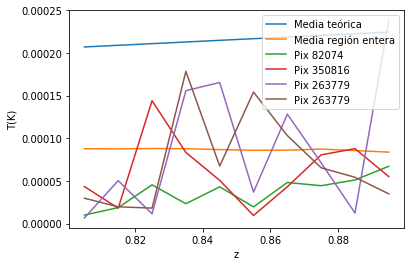

In [7]:
plt.figure()
plt.plot(z_bin_centers,Tb_media(z_bin_centers),label='Media teórica')
plt.plot(z_bin_centers,T_bins_mollview_medias_todo_mapa,label='Media región entera')
plt.plot(z_bin_centers,T_bins_mollview_medias_pix1,label='Pix {:.0f}'.format(pix1))
plt.plot(z_bin_centers,T_bins_mollview_medias_pix2,label='Pix {:.0f}'.format(pix2))
plt.plot(z_bin_centers,T_bins_mollview_medias_pix3,label='Pix {:.0f}'.format(pix4))
plt.plot(z_bin_centers,T_bins_mollview_medias_pix4,label='Pix {:.0f}'.format(pix4))
plt.xlabel('z')
plt.ylabel('T(K)')
plt.legend()
plt.savefig('../Plots/Plot_temperaturas_medias_bins_disp.png',bbox_inches='tight')
plt.show()